In [7]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
 
import matplotlib.pyplot as plt

# get data
data = pd.read_pickle("./data/datasets/islets_rna_prot_dataset.pkl")
sample_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_sample_metadata.pkl")
feature_metadata = pd.read_pickle("./data/datasets/islets_rna_prot_feature_metadata.pkl")

sys.path.append("src.py")
from src import Utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [F01] Supplementary figure on CVs:

Inter-replicate precision for proteomics and transcriptomics data. Both measurements are expected to show high precision between biological replicates.

3273 proteins with 100 % data completeness.


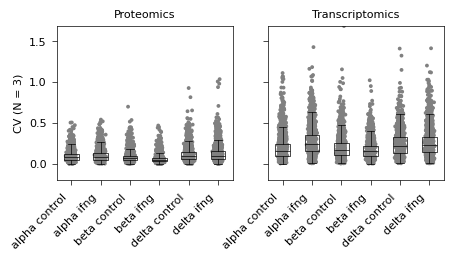

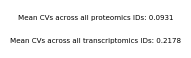

In [12]:
def fig_01_inter_replicate_data(
        data : pd.DataFrame = None,
        sample_metadata: pd.DataFrame = None,
):

    # reverse log2 transformation‚
    data = 2**data

    # restrict to basically 100 % data completeness for fair comparison
    max_missing = 0.00001
    mval_percentage = data.isna().mean()
    missingness = mval_percentage >= max_missing
    data = data.loc[:, ~missingness]
    print(f'{data.shape[1]} proteins with 100 % data completeness.')

    # calculate inter-replicate CVs for each protein in each cell type
    readouts = ['proteomics', 'transcriptomics']
    samples = ['alpha', 'beta', 'delta']
    treatment = ['control', 'ifng']

    # iterate over conditions and filter
    cv_dataframes = []
    for readout in readouts:
        for sample in samples:
            for treat in treatment:
                
                # filter data
                idxs = sample_metadata[
                    (sample_metadata['sample'] == sample) & 
                    (sample_metadata['readout'] == readout) & 
                    (sample_metadata['treat'] == treat)].index
                
                # compute CVs: CV = std/mean
                dfi = data.loc[idxs]

                # check for the presence of all replicates
                if dfi.shape[0] != 3:
                    raise ValueError(f"Not all 3 replicates present!: {sample}, {treat}, {readout}")
                
                # calculate CV across all proteins
                cv = dfi.std(axis = 0) / dfi.mean(axis = 0)
                cv.name = f'{sample}_{treat}_{readout}_cv'

                # append to list
                cv_dataframes.append(cv)

    # concatenate and return
    cv_df = pd.concat(cv_dataframes, axis = 1).T

    return cv_df
                
# visualize as boxplot
def fig_01_inter_replicate_boxplots(cv_df):

    cv_df = cv_df.copy()

    # parse index to different metadata values
    cv_md = pd.DataFrame({'identifier' : cv_df.index.tolist()}, index = cv_df.index)
    cv_md['sample'] = cv_md['identifier'].str.split('_').str[0]
    cv_md['treat'] = cv_md['identifier'].str.split('_').str[1]
    cv_md['readout'] = cv_md['identifier'].str.split('_').str[2]
    cv_md.drop('identifier', inplace = True, axis = 1)

    # melt cv_df to have two three columns: identifier, protein, CV
    cv_df['identifier'] = cv_df.index
    cv_df_melted = cv_df.melt(id_vars = 'identifier', var_name = 'protein', value_name = 'cv')
    cv_df_melted = cv_df_melted.set_index('identifier', drop = False)

    # align melted datasets
    cv_df_melted, cv_md_melted = cv_df_melted.align(cv_md, axis = 0)

    # cleaning plot labels
    def clean_xlab(l):
        l = l.replace('_cv', '')
        l = l.replace('_', ' ')
        l = l.replace('proteomics', '')
        l = l.replace('transcriptomics', '')
        return l
    
    label_parse_dict = {
        '_facet: single': 'CV across replicates',
        'identifier' : '',
        'cv' : 'CV (N = 3)',
        'readout: proteomics' : 'Proteomics',
        'readout: transcriptomics' : 'Transcriptomics',}

    # coloring
    cv_df_melted['color_col'] = 'grey'

    # boxplot
    f, a = Utils.boxplot(
        data = cv_df_melted,
        metadata = cv_md_melted,
        value_col = 'cv',
        grouping_col = 'identifier',
        subplot_col = 'readout',
        figsize_x = 2.5,
        figsize_y = 2,
        label_general_regex = clean_xlab,
        label_lookup_dict=label_parse_dict,
        normal_jitter = 0.05,
        highlight_lookup_column = 'protein',
        highlight_labels_column = 'protein',
        scatter_kwargs = {'s': 3},
        xtick_kwargs = {'rotation': 45, 'ha' : 'right'},
        ylim_padding = (0.2, 0),
        single_color = 'grey'
    )

    # save plot
    Utils.save_figure(
        fig = f, 
        filename = f"fig_01.svg",
        output_dir = "./assets/20250423_revision_figures",
        dpi = 300,
        paper_width = "double",
        paper_height = "0.75",
    )
    
sf_5_cvdf = fig_01_inter_replicate_data(data, sample_metadata)
fig_01_inter_replicate_boxplots(sf_5_cvdf)

# show mean CVs
p_cvs = sf_5_cvdf[sf_5_cvdf.index.str.contains('proteomics')].mean(axis = 1).mean()
t_cvs = sf_5_cvdf[sf_5_cvdf.index.str.contains('transcriptomics')].mean(axis = 1).mean()

# save numbers
fig, ax = plt.subplots(figsize=(2,0.5))
ax.axis('off')
ax.text(0.5, 0.8, f"Mean CVs across all proteomics IDs: {round(p_cvs, 4)}", ha='center', va='center')
ax.text(0.5, 0.2, f"Mean CVs across all transcriptomics IDs: {round(t_cvs, 4)}", ha='center', va='center')
plt.savefig(
    "./assets/20250423_revision_figures/fig_01_mean_cvs.svg", 
    dpi=300, 
    bbox_inches='tight',
    transparent=True,
)